<a href="https://colab.research.google.com/github/mrromaniuc/quantum-computing/blob/main/QC_Groove_Algo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#%%capture
#@title
#Installing qiskit standalone
!pip install imgaug==0.2.5
#!pip install qiskit==0.36.1
!pip install qiskit -U
!pip install pylatexenc
#Next lines for LaTeX
#!pip install latex
#!apt-get install cm-super
#!apt-get install dvipng 
#!apt install texlive texlive-latex-extra texlive-fonts-recommended dvipng


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
from qiskit import *
from qiskit.visualization import plot_bloch_multivector, array_to_latex
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

import qiskit.quantum_info as qi
from qiskit.quantum_info.operators  import Operator, Pauli

from scipy import linalg as lng
import matplotlib.pyplot as plt

In [ ]:
#Basic methods...
def run(qc):
  svsim = Aer.get_backend('aer_simulator')
  qc.save_statevector()
  job = svsim.run(qc)
  return job.result()

def plot(qc, op=None, sv=None):
  if (qc!= None):
    display(qc.draw("mpl"))
  if (op!=None):
    display(array_to_latex(op, prefix="Operator = "))
  if (sv != None):
    display(array_to_latex(sv, prefix="\\text{Statevector = }"))
    display(plot_bloch_multivector(sv))

In [ ]:
import math

#First Oracle, considering the omega to be searched
def getOpUf(wket):
  wbra = np.conjugate(wket.T)
  dim = wket.shape[0]
  op = np.identity(dim) - 2*wket@wbra
  return Operator(op)

#Second Oracle, using the |00....0> vector 
def getOpUf0(qc):
  dim = 2**qc.num_qubits
  vket = np.array([[1] if i==0 else [0] for i in range(dim)])
  vbra = np.conjugate(vket.T)
  op = 2*vket@vbra - np.identity(dim)
  return Operator(op)

#Adding Hadamard to all qubits in the circuit
def addH(qc):
  for i in range(qc.num_qubits):
    qc.h(i)
  return qc

#Creating the block which needs to be repeated...
def addBlock(wket, qc, b_num):
  pos = [i for i in range(qc.num_qubits)]

  qc.save_statevector(label="psi1_" + str(b_num))
  qc.unitary(getOpUf(wket), pos, ' Uf_'+str(b_num))

  qc.save_statevector(label="psi2_" + str(b_num))
  qc = addH(qc)

  qc.save_statevector(label="psi3_" + str(b_num))
  qc.unitary(getOpUf0(qc), pos, ' Uf0_'+str(b_num))

  qc.save_statevector(label="psi4_" + str(b_num))
  qc = addH(qc)

  qc.save_statevector(label="psi5_" + str(b_num))
  return qc

#Add the final measures...
def addMeasure(qc):
  for i in range(qc.num_qubits):
    qc.measure(i,i)
  return qc

#Calculate the number of repetitions for the block
def calcR(qc):
  return math.ceil(np.pi/(4*np.arcsin(1/np.sqrt(2**qc.num_qubits))) - 1/2)
                   
#Create the Groove Circuit...
def crGrove(omega, nqubits):
  qc = QuantumCircuit(nqubits, nqubits)
  qc.save_statevector(label="psi0")
  qc = addH(qc)
  for i in range(calcR(qc)):
    qc = addBlock(omega, qc, i)
  qc = addMeasure(qc)
  return qc

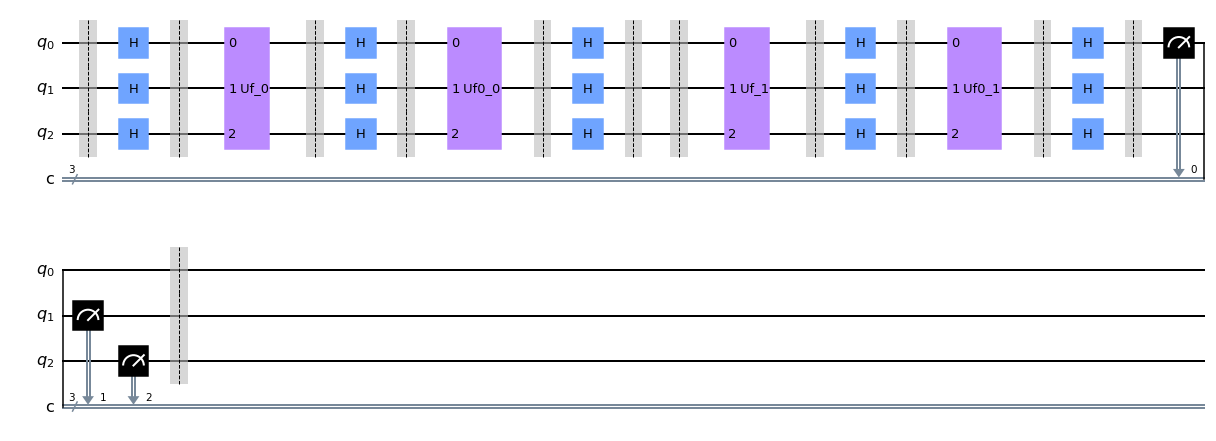

In [ ]:
v03 = np.array([[0], [0], [0], [1]])
v003 = np.array([[0], [0], [0], [1], [0], [0], [0], [0]])

qc = crGrove(v003, 3)

result = run(qc)
plot(qc=qc, op=None, sv=None)

In [ ]:
def plotSv(svname):
  st = result.data(0)[svname].data
  print(st)
  #nst = np.sqrt(st*np.conjugate(st.T))
  nst = st
  plt.bar([i for i in range(len(nst))], nst)
  plt.ylim(-1, 1)
  plt.xticks(range(len(st)))

[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]


/usr/local/lib/python3.7/dist-packages/matplotlib/transforms.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)


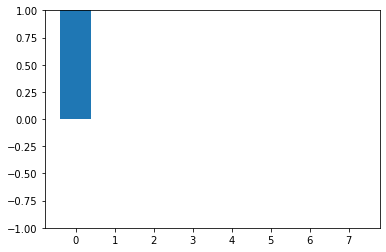

In [ ]:
plotSv("psi0")

In [ ]:
st = result.data(0)['psi1_0'].data
st*np.conjugate(st.T)

array([0.125+0.j, 0.125+0.j, 0.125+0.j, 0.125+0.j, 0.125+0.j, 0.125+0.j,
       0.125+0.j, 0.125+0.j])

[0.35355339+0.j 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j
 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j]


/usr/local/lib/python3.7/dist-packages/matplotlib/transforms.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)


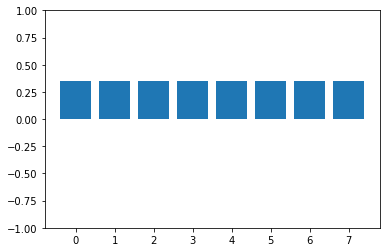

In [ ]:
plotSv("psi1_0")

[ 0.35355339+0.j  0.35355339+0.j  0.35355339+0.j -0.35355339+0.j
  0.35355339+0.j  0.35355339+0.j  0.35355339+0.j  0.35355339+0.j]


/usr/local/lib/python3.7/dist-packages/matplotlib/transforms.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)


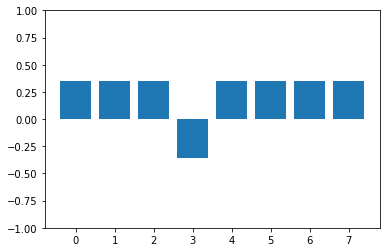

In [ ]:
plotSv("psi2_0")

[ 0.75-1.22464680e-16j  0.25+2.96009274e-33j  0.25-1.39778926e-33j
 -0.25+6.12323400e-17j -0.25+1.22464680e-16j  0.25-6.12323400e-17j
  0.25-6.12323400e-17j -0.25+6.12323400e-17j]


/usr/local/lib/python3.7/dist-packages/matplotlib/transforms.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)


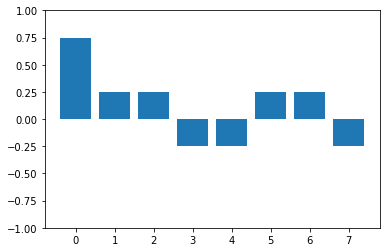

In [ ]:
plotSv("psi3_0")

[ 0.75-1.22464680e-16j -0.25-2.96009274e-33j -0.25+1.39778926e-33j
  0.25-6.12323400e-17j  0.25-1.22464680e-16j -0.25+6.12323400e-17j
 -0.25+6.12323400e-17j  0.25-6.12323400e-17j]


/usr/local/lib/python3.7/dist-packages/matplotlib/transforms.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)


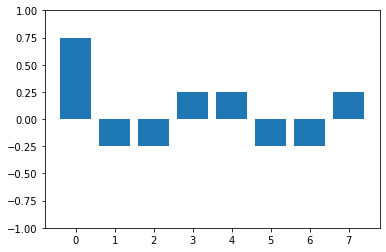

In [ ]:
plotSv("psi4_0")

[0.1767767 -8.65956056e-17j 0.1767767 -9.68719914e-34j
 0.1767767 +1.94192954e-32j 0.88388348-3.03084620e-16j
 0.1767767 -4.32978028e-17j 0.1767767 +2.57369523e-32j
 0.1767767 +1.19359824e-32j 0.1767767 +8.65956056e-17j]


/usr/local/lib/python3.7/dist-packages/matplotlib/transforms.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)


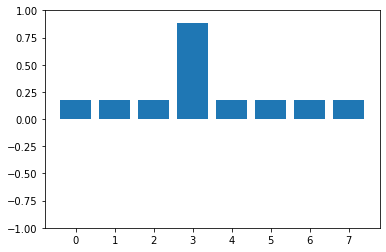

In [ ]:
plotSv("psi5_0")

[0.1767767 -8.65956056e-17j 0.1767767 -9.68719914e-34j
 0.1767767 +1.94192954e-32j 0.88388348-3.03084620e-16j
 0.1767767 -4.32978028e-17j 0.1767767 +2.57369523e-32j
 0.1767767 +1.19359824e-32j 0.1767767 +8.65956056e-17j]


/usr/local/lib/python3.7/dist-packages/matplotlib/transforms.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)


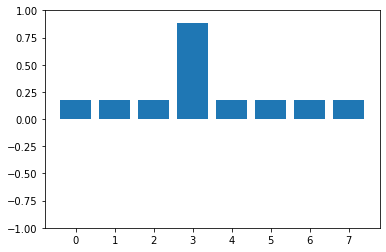

In [ ]:
plotSv("psi1_1")

[ 0.1767767 -8.65956056e-17j  0.1767767 -9.68719914e-34j
  0.1767767 +1.94192954e-32j -0.88388348+3.03084620e-16j
  0.1767767 -4.32978028e-17j  0.1767767 +2.57369523e-32j
  0.1767767 +1.19359824e-32j  0.1767767 +8.65956056e-17j]


/usr/local/lib/python3.7/dist-packages/matplotlib/transforms.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)


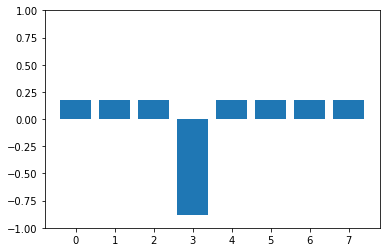

In [ ]:
plotSv("psi2_1")

[ 0.125+9.18485099e-17j  0.375-2.44929360e-16j  0.375-2.44929360e-16j
 -0.375+1.83697020e-16j -0.375+1.83697020e-16j  0.375-1.83697020e-16j
  0.375-1.83697020e-16j -0.375+1.53080850e-16j]


/usr/local/lib/python3.7/dist-packages/matplotlib/transforms.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)


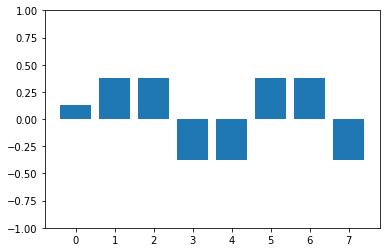

In [ ]:
plotSv("psi3_1")

[ 0.125+9.18485099e-17j -0.375+2.44929360e-16j -0.375+2.44929360e-16j
  0.375-1.83697020e-16j  0.375-1.83697020e-16j -0.375+1.83697020e-16j
 -0.375+1.83697020e-16j  0.375-1.53080850e-16j]


/usr/local/lib/python3.7/dist-packages/matplotlib/transforms.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)


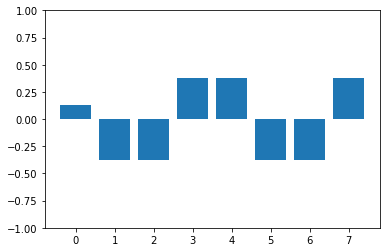

In [ ]:
plotSv("psi4_1")

[-0.08838835+1.51542310e-16j -0.08838835+1.51542310e-16j
 -0.08838835+1.51542310e-16j  0.97227182-6.49467042e-16j
 -0.08838835+1.29893408e-16j -0.08838835+1.08244507e-16j
 -0.08838835+1.08244507e-16j -0.08838835+1.08244507e-16j]


/usr/local/lib/python3.7/dist-packages/matplotlib/transforms.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)


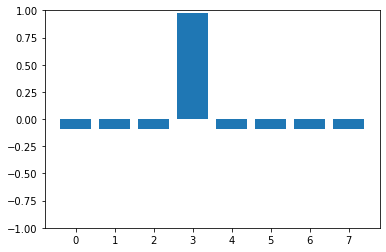

In [ ]:
plotSv("psi5_1")

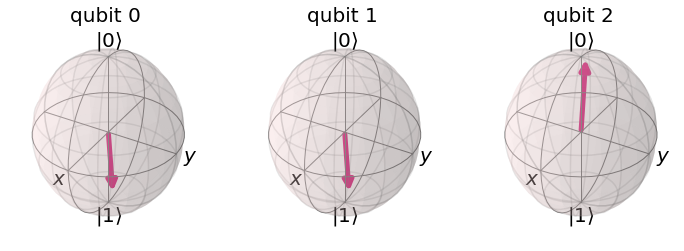

In [ ]:
plot_bloch_multivector(result.data(0)['psi5_1'])